# Dummy data
**Goal**: Create dummy data to test the estimator on

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [141]:
class LoessSmoother:
    def __init__(self, model=LinearRegression, window=20, step_size=0.2):
        self.window = window
        self.model = model()
        self.n_points = window
        self.step_size = step_size

    def generate_reg_indexes(self, X):
        """Return the focal points and the indices of the x values in their accompanying windows"""
        x_focal = X.min()
        x_max = X.max()

        while x_focal <= x_max:
            yield x_focal, np.argwhere((X > (x_focal - self.window)) & (X < (x_focal + self.window)))
            x_focal += self.step_size

    def get_closest_points(self, X, x_focal):
        """return the indices of the nearest points in dataset X to datapoint x_focus"""
        knn = NearestNeighbors(n_neighbors=self.n_points).fit(X.reshape(-1, 1))
        return knn.kneighbors(x_focal)[1][0]

    def fit(self, X, y):
        sorting_idx = np.argsort(X)
        X = X[sorting_idx]
        y = y[sorting_idx]
        points_generator = self.generate_reg_indexes(X)
        y_focal = np.array([])

        x_focal_base = np.array([])
        for x_focal, idx_window in points_generator:

            x_focal = x_focal.reshape(-1, 1)
            x_window = X[idx_window].reshape(-1, 1)
            y_window = y[idx_window]

            # Not possible to fit on less than 2 points for linear
            # TODO: Flex to work with polynomials
            if len(idx_window) < self.window:  
                x_window, y_window = self.get_interpolation_ends(X, y, x_focal)

            y_focal_new = self.model.fit(x_window.reshape(-1,1), y_window).predict(x_focal)

            y_focal = np.append(y_focal, y_focal_new)
            x_focal_base = np.append(x_focal_base, x_focal)
        return y_focal, x_focal_base
    
    def get_interpolation_ends(self, X, y, x_focal):
        # Split data in before missing data and after missing data
        idx_below_x_focal = np.nonzero(X.flatten() < x_focal)
        idx_above_x_focal = np.nonzero(X.flatten() > x_focal)
        
        X_low = X[idx_below_x_focal[1]]
        y_low = y[idx_below_x_focal[1]]
        
        X_high = X[idx_above_x_focal[1]]
        y_high = y[idx_above_x_focal[1]]

        # filter indices to last and first window points
        idx_low = np.argpartition(X_low, -self.window)[-self.window:]
        idx_high = np.argpartition(X_high, self.window)[:self.window]

        # Create subset of data around missing data
        X_low = X_low[idx_low]
        y_low = y_low[idx_low]

        X_high = X_high[idx_high]
        y_high = y_high[idx_high]

        X_interpolate = np.append(X_low, X_high)
        y_interpolate =  np.append(y_low, y_high)
        
        return X_interpolate, y_interpolate

In [142]:
def random_x(minimum_val, maximum_val, size):
    """
    Generate n random data-points of size between minimum_val and right bounds
    :param minimum_val: float, minimal value of the generated data
    :param maximum_val: float, maximum value of the generated data
    :param size: tuple or list, shape of the desired output
    :return: np.Array with generated data
    """
    return (maximum_val - minimum_val) * np.random.random(size=size) + minimum_val


def generate_data(x, generate_function, noise_std):
    """
    Return f(x) with added normal distributed noise with standard deviation noise_std.
    :param x: np.Array, input data
    :param generate_function: function to apply to input data
    :param noise_std: non-negative float, standard deviation of added noise.
    :return: np.Array, y = f(x) + N(0, std)
    """
    return generate_function(x) + np.random.normal(loc=0, scale=noise_std, size=x.shape)

In [143]:
np.exp(0)

1.0

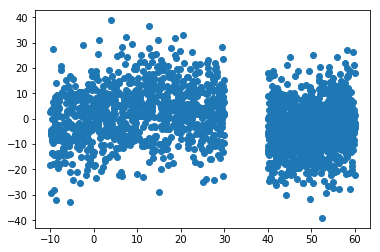

In [214]:
x1 = random_x(-10, 30, 1000)
x2 = random_x(40, 60, 1000)
x = np.append(x1, x2)
np.random.shuffle(x)
noise_std=10
y = 5*np.sin(x/10) + np.random.normal(loc=0, scale=noise_std, size=x.shape)

plt.scatter(x, y)

In [215]:
x.reshape(-1,1)

array([[55.82498581],
       [17.09673103],
       [43.31351225],
       ...,
       [56.18340187],
       [22.69006134],
       [11.90011375]])

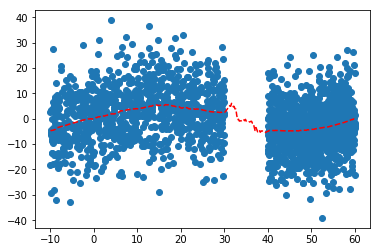

In [216]:
window = 7
estimator = LoessSmoother(window=window)
y_new, x_new = estimator.fit(x,y)
plt.scatter(x, y)
plt.plot(x_new,y_new, 'r--')

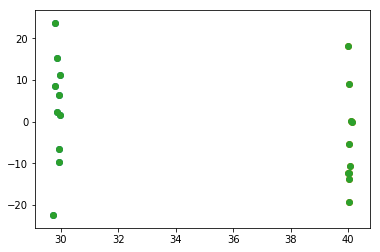

In [217]:
x_focal = 35
n_points = 10
idx_below_x_focal = np.nonzero(x < x_focal)
idx_above_x_focal = np.nonzero(x > x_focal)

X_low = x[idx_below_x_focal]
y_low = y[idx_below_x_focal]

idx_low = np.argpartition(X_low, -n_points)[-n_points:]

X_low = X_low[idx_low]
y_low = y_low[idx_low]

X_high = x[idx_above_x_focal]
y_high = y[idx_above_x_focal]

idx_high = np.argpartition(X_high, n_points)[:n_points]

X_high = X_high[idx_high]
y_high = y_high[idx_high]

X_interpolate = np.append(X_low, X_high)
y_interpolate =  np.append(y_low, y_high)

plt.scatter(X_low, y_low)
plt.scatter(X_high, y_high)
plt.scatter(X_interpolate, y_interpolate)